In [1]:

# NOTEBOOK 3: PYTHON ANALYSIS & MACHINE LEARNING
## 1. Setup - Import Libraries and Mount Google Drive
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Machine Learning - Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Machine Learning - Forecasting
from prophet import Prophet

# Machine Learning - Classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define file paths
cleaned_csv_path = '/content/drive/MyDrive/Advanced Retail Analytics project/cleaned_superstore.csv'
rfm_csv_path = '/content/drive/MyDrive/Advanced Retail Analytics project/rfm_analysis.csv'

print("Setup Complete.")

Mounted at /content/drive
Setup Complete.


In [2]:
## Part 1: Exploratory Data Analysis (EDA)
# -----------------------------------------------------------------------------
# First, let's load the main dataset and set a consistent style for our plots.
df = pd.read_csv(cleaned_csv_path, parse_dates=['order_date', 'ship_date'])
sns.set_style("whitegrid")
print("Dataset loaded for Exploratory Data Analysis.")

Dataset loaded for Exploratory Data Analysis.



--- Visualizing Sales and Profit Over Time ---


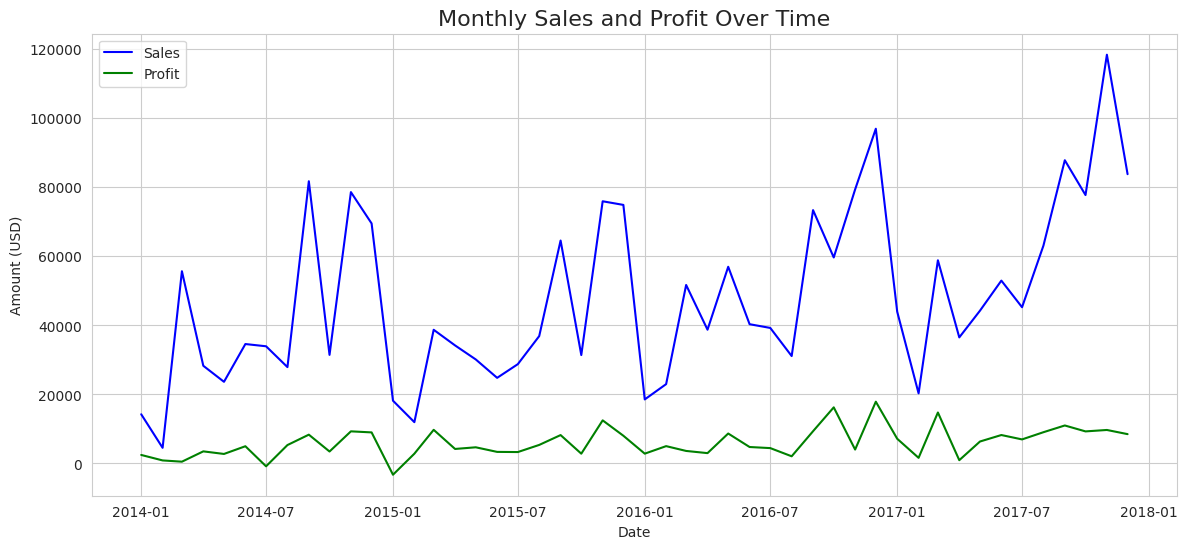

In [4]:
# --- 1.1 Sales and Profit Over Time ---
print("\n--- Visualizing Sales and Profit Over Time ---")
# Aggregate data by month
monthly_analysis = df.set_index('order_date')[['sales', 'profit']].resample('MS').sum()

plt.figure(figsize=(14, 6))
plt.plot(monthly_analysis.index, monthly_analysis['sales'], label='Sales', color='blue')
plt.plot(monthly_analysis.index, monthly_analysis['profit'], label='Profit', color='green')
plt.title('Monthly Sales and Profit Over Time', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Amount (USD)')
plt.legend()
plt.show()
# INSIGHT: This chart shows the overall business growth and seasonality. We can see sales and profit generally trend upwards, with noticeable peaks towards the end of the year.



--- Analysis by Product Category ---


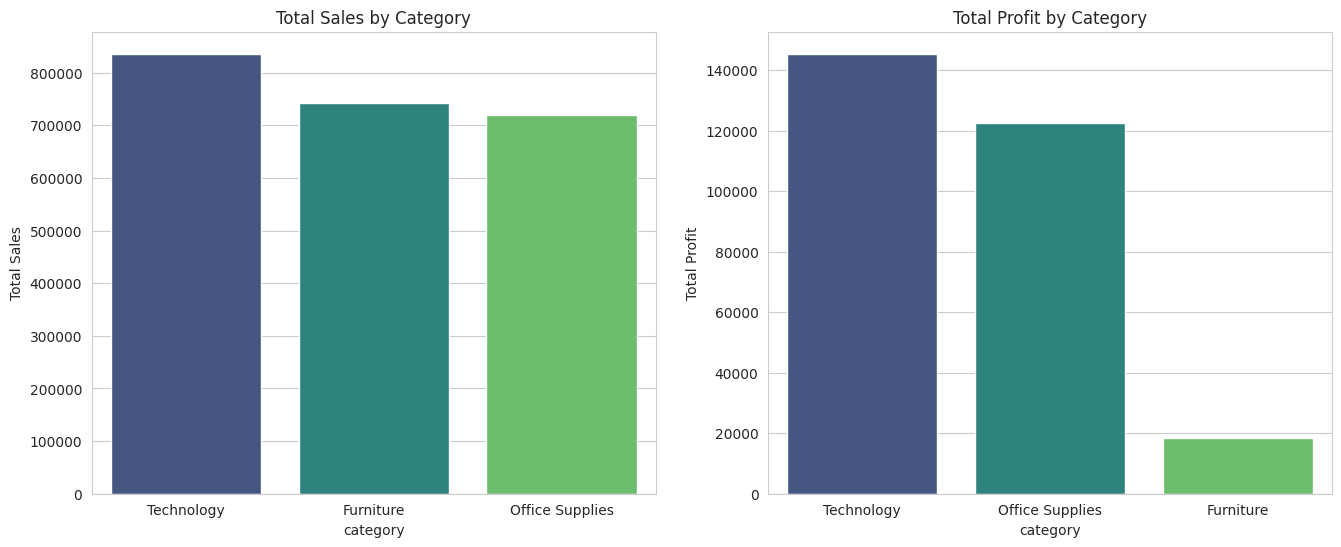

In [5]:
# --- 1.2 Sales and Profit by Category and Sub-Category ---
print("\n--- Analysis by Product Category ---")
# Group by Category
category_profit = df.groupby('category')['profit'].sum().reset_index().sort_values(by='profit', ascending=False)
category_sales = df.groupby('category')['sales'].sum().reset_index().sort_values(by='sales', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# Plot for Sales
sns.barplot(data=category_sales, x='category', y='sales', hue='category', palette='viridis', legend=False, ax=axes[0])
axes[0].set_title('Total Sales by Category')
axes[0].set_ylabel('Total Sales')
# Plot for Profit
sns.barplot(data=category_profit, x='category', y='profit', hue='category', palette='viridis', legend=False, ax=axes[1])
axes[1].set_title('Total Profit by Category')
axes[1].set_ylabel('Total Profit')
plt.show()
# INSIGHT: Technology is the highest in both sales and profit. Furniture has high sales but shockingly low profit, which is a key area for investigation.



--- Relationship between Sales, Profit, and Discount ---


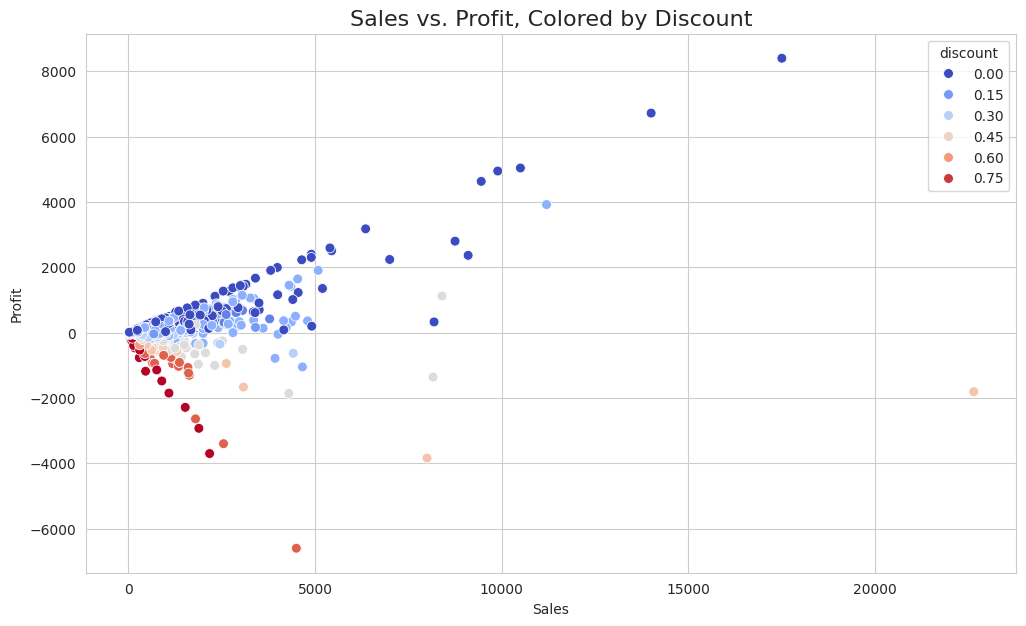

In [6]:
# --- 1.3 The Relationship Between Sales, Profit, and Discount ---
print("\n--- Relationship between Sales, Profit, and Discount ---")
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df, x='sales', y='profit', hue='discount', palette='coolwarm', s=50)
plt.title('Sales vs. Profit, Colored by Discount', fontsize=16)
plt.xlabel('Sales')
plt.ylabel('Profit')
plt.show()
# INSIGHT: This is a critical visualization. It clearly shows that higher discounts (redder points) are strongly associated with negative profit, even on high-sales items. This confirms that 'discount' will be a very important feature for our profitability prediction model.



--- Profitability of Sub-Categories ---


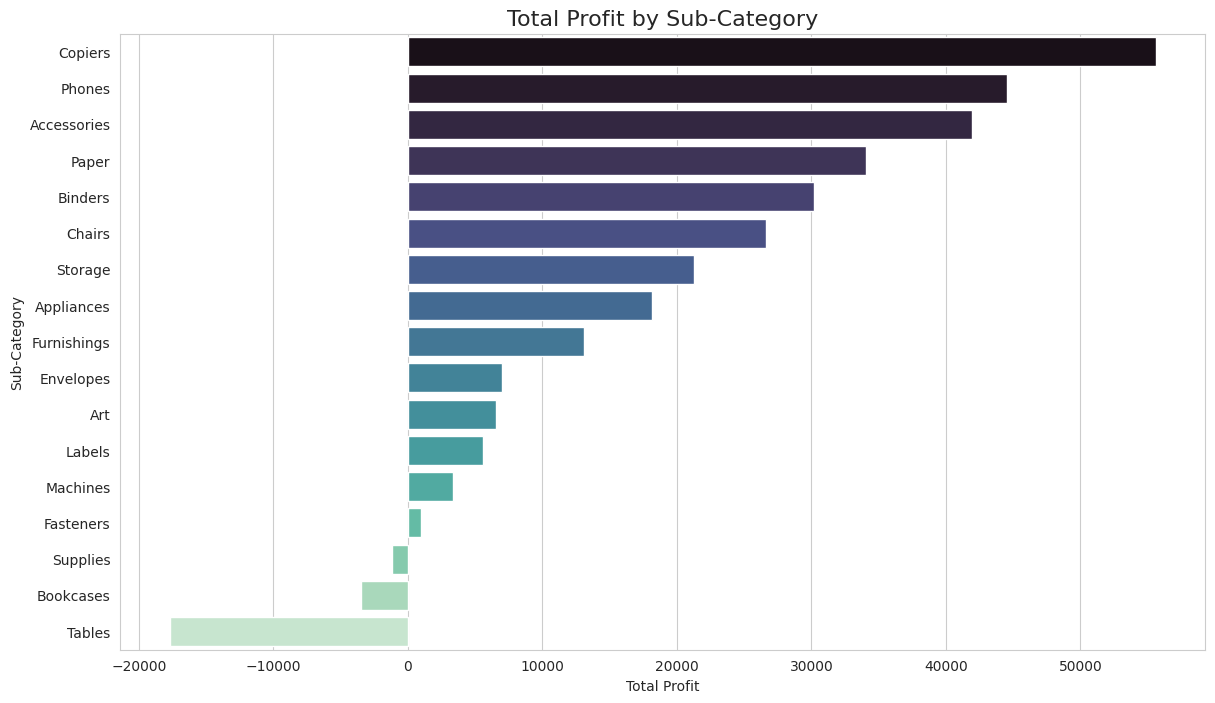

In [7]:
# --- 1.4 Profitability by Sub-Category ---
print("\n--- Profitability of Sub-Categories ---")
subcategory_profit = df.groupby('sub_category')['profit'].sum().reset_index().sort_values(by='profit', ascending=False)
plt.figure(figsize=(14, 8))
sns.barplot(data=subcategory_profit, y='sub_category', x='profit', hue='sub_category', palette='mako', legend=False)
plt.title('Total Profit by Sub-Category', fontsize=16)
plt.xlabel('Total Profit')
plt.ylabel('Sub-Category')
plt.show()
# INSIGHT: This drill-down is crucial. It reveals that 'Tables', 'Bookcases', and 'Supplies' are the primary drivers of unprofitability. 'Copiers' and 'Phones' are the most profitable. This provides actionable insights for the business.


--- Sales by Region ---


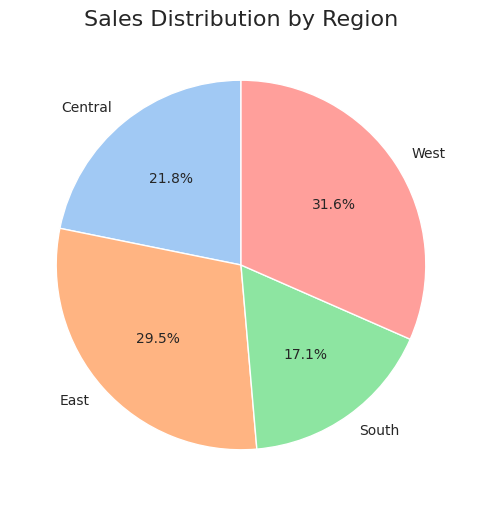

In [8]:
# --- 1.5 Sales Distribution by Region ---
print("\n--- Sales by Region ---")
region_sales = df.groupby('region')['sales'].sum().reset_index()
plt.figure(figsize=(10, 6))
plt.pie(region_sales['sales'], labels=region_sales['region'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Sales Distribution by Region', fontsize=16)
plt.ylabel('') # Hides the 'sales' label on the side
plt.show()
# INSIGHT: The sales are fairly evenly distributed across the regions, with the West and East leading slightly.

In [10]:
## Part 1: Customer Segmentation
# -----------------------------------------------------------------------------
# Load the RFM data created in the SQL notebook
rfm_df = pd.read_csv(rfm_csv_path)
print("RFM data loaded:")
display(rfm_df.head())

RFM data loaded:


,customer_id,customer_name,recency,frequency,monetary
0,SM-20320,Sean Miller,80.0,5,25043.050
1,TC-20980,Tamara Chand,400.0,5,19052.218
2,RB-19360,Raymond Buch,97.0,6,15117.339
3,TA-21385,Tom Ashbrook,70.0,4,14595.620
4,AB-10105,Adrian Barton,42.0,10,14473.571


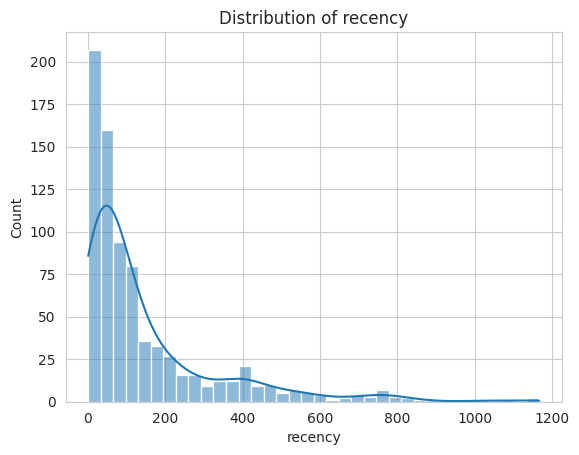

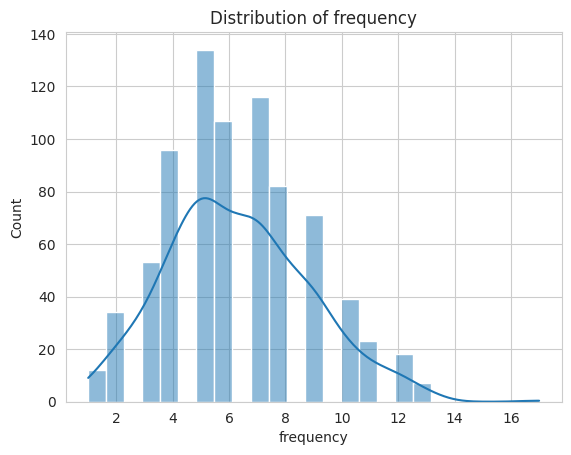

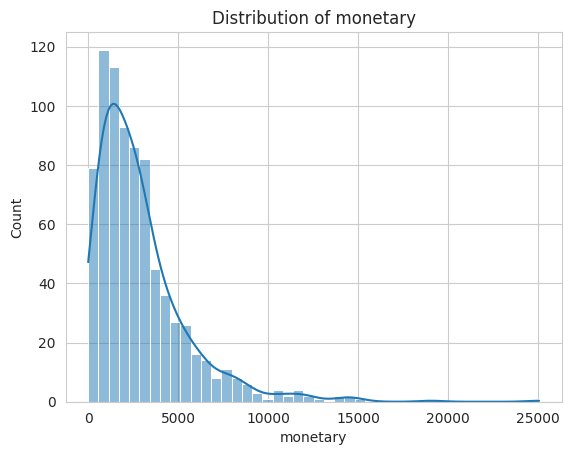

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in ['recency', 'frequency', 'monetary']:
    sns.histplot(rfm_df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()


In [12]:
# --- 1.1 Prepare Data for Clustering ---
# We only need the R, F, and M columns for clustering
rfm_features = rfm_df[['recency', 'frequency', 'monetary']]

# K-Means is sensitive to the scale of data, so we must scale our features.
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)
print("\nRFM features scaled successfully.")


RFM features scaled successfully.


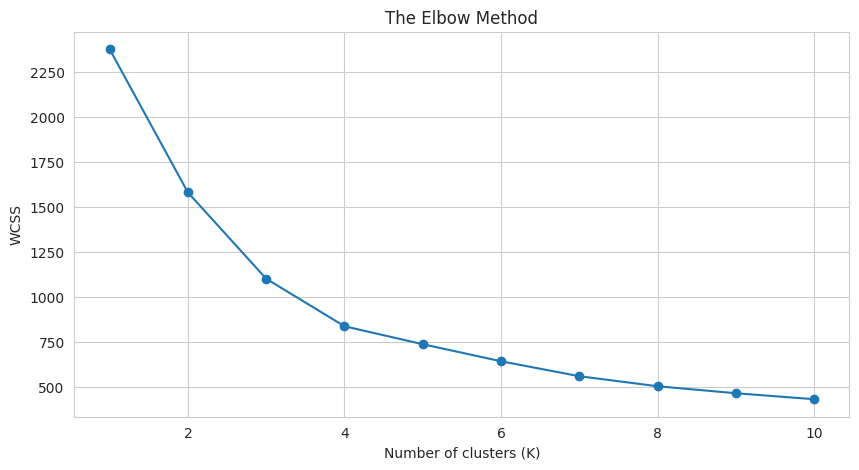

In [13]:
# --- 1.2 Find the Optimal Number of Clusters (K) using the Elbow Method ---
wcss = [] # Within-Cluster Sum of Squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()
# NOTE: Based on the plot, choose the 'elbow' point. Let's assume K=4 for this example.

In [14]:
# --- 1.3 Apply K-Means with the Chosen K ---
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=300, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(rfm_scaled)

# Add the cluster labels to our original RFM dataframe
rfm_df['cluster'] = cluster_labels
print(f"\nK-Means applied with K={optimal_k}.")



K-Means applied with K=4.



--- Cluster Analysis (Mean RFM Values) ---


,cluster,recency,frequency,monetary
0,0,101.909910,4.714715,1680.496499
1,1,119.342857,8.242857,9208.291266
2,2,559.489583,3.697917,1470.228226
3,3,72.129252,8.527211,3237.664040


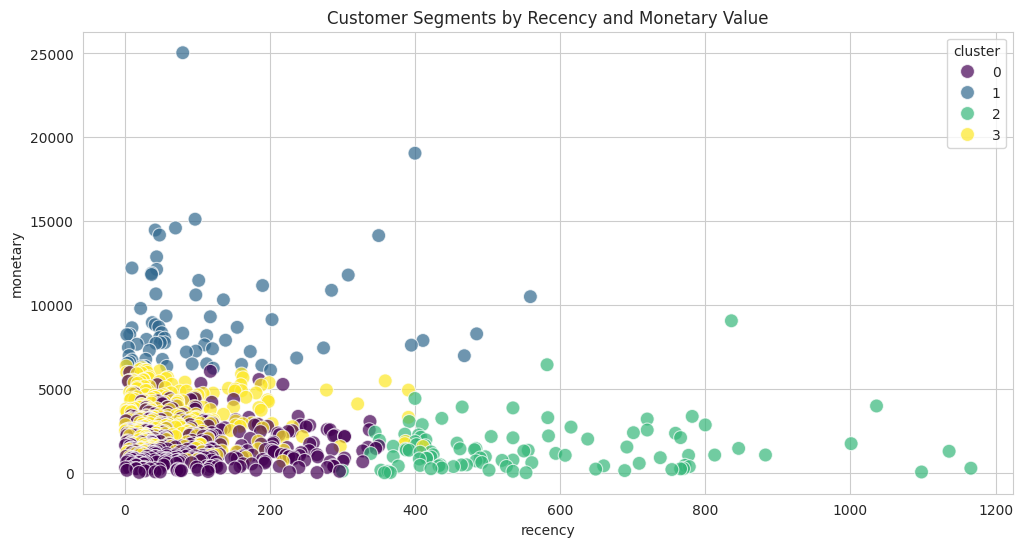

In [15]:
# --- 1.4 Analyze and Interpret the Segments ---
# Calculate the mean RFM values for each cluster
cluster_analysis = rfm_df.groupby('cluster')[['recency', 'frequency', 'monetary']].mean().reset_index()
print("\n--- Cluster Analysis (Mean RFM Values) ---")
display(cluster_analysis)

# Visualize the clusters
plt.figure(figsize=(12, 6))
sns.scatterplot(data=rfm_df, x='recency', y='monetary', hue='cluster', palette='viridis', s=100, alpha=0.7)
plt.title('Customer Segments by Recency and Monetary Value')
plt.show()

# Interpretation: Based on the means, you can name your clusters.
# For example:
# Low Recency, High Frequency, High Monetary -> "Champions" or "Loyal Customers"
# High Recency, Low Frequency, Low Monetary -> "At-Risk" or "Lost Customers"
# Low Recency, Low Frequency, Low Monetary -> "New Customers"

In [16]:
# --- (Add this to the end of Part 2) ---
# Save the RFM dataframe with the cluster labels for Power BI
segmented_customers_path = '/content/drive/MyDrive/Advanced Retail Analytics project/segmented_customers.csv'
rfm_df.to_csv(segmented_customers_path, index=False)

print(f"\nCustomer segmentation results saved to: {segmented_customers_path}")


Customer segmentation results saved to: /content/drive/MyDrive/Advanced Retail Analytics project/segmented_customers.csv


In [17]:
## Part 2: Sales Forecasting
# -----------------------------------------------------------------------------
# Load the main cleaned dataset
df = pd.read_csv(cleaned_csv_path, parse_dates=['order_date'])
print("\nMain dataset loaded for forecasting.")



Main dataset loaded for forecasting.


In [18]:
# --- 2.1 Prepare Data for Prophet ---
# Prophet requires the dataframe to have two columns: 'ds' (datestamp) and 'y' (value).
# Let's aggregate sales by month.
sales_monthly = df.set_index('order_date')['sales'].resample('MS').sum().reset_index()
sales_monthly.rename(columns={'order_date': 'ds', 'sales': 'y'}, inplace=True)
print("\nMonthly sales data prepared for Prophet:")
display(sales_monthly.head())


Monthly sales data prepared for Prophet:


,ds,y
0,2014-01-01,14236.895
1,2014-02-01,4519.892
2,2014-03-01,55691.009
3,2014-04-01,28295.345
4,2014-05-01,23648.287


In [19]:
# --- 2.2 Train the Prophet Model ---
# Initialize and fit the model
model = Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(sales_monthly)
print("\nProphet model trained.")


DEBUG:cmdstanpy:input tempfile: /tmp/tmp73as7qqy/a2cvtxkf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp73as7qqy/kwwl80b9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65671', 'data', 'file=/tmp/tmp73as7qqy/a2cvtxkf.json', 'init=/tmp/tmp73as7qqy/kwwl80b9.json', 'output', 'file=/tmp/tmp73as7qqy/prophet_modelteovxf9a/prophet_model-20250824140422.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:04:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:04:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Prophet model trained.


In [20]:
# --- 2.3 Make Future Predictions ---
# Create a dataframe for future dates (12 months)
future = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future)
print("Forecast for the next 12 months created.")


Forecast for the next 12 months created.


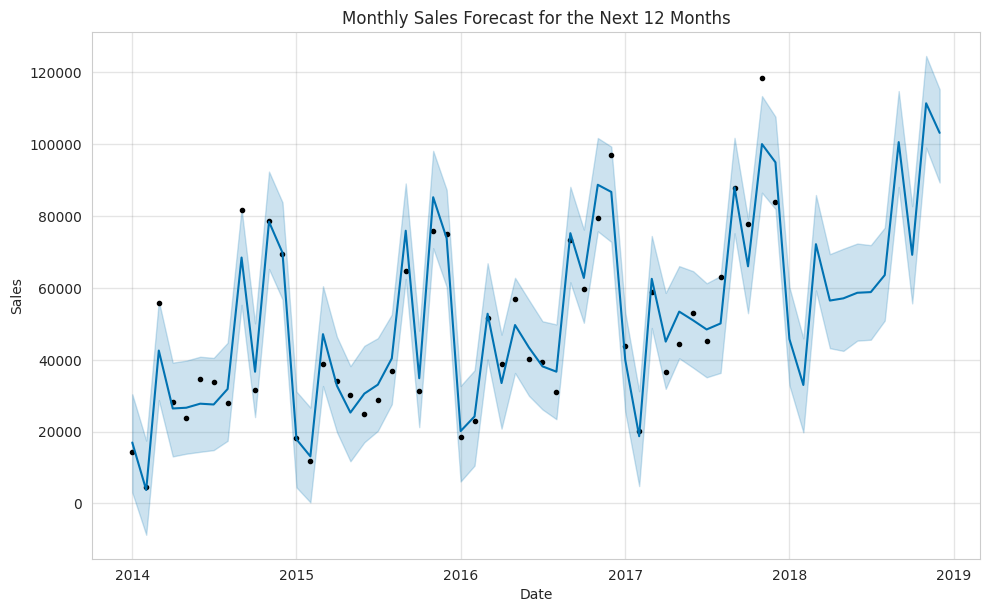

In [21]:
# --- 2.4 Visualize the Forecast ---
fig1 = model.plot(forecast)
plt.title('Monthly Sales Forecast for the Next 12 Months')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [22]:
# Add this to the end of your Prophet section in the Python notebook
forecast_path = '/content/drive/MyDrive/Advanced Retail Analytics project/sales_forecast.csv'
forecast.to_csv(forecast_path, index=False)
print(f"Forecast data saved to: {forecast_path}")

Forecast data saved to: /content/drive/MyDrive/Advanced Retail Analytics project/sales_forecast.csv


In [ ]:
## Part 3: Profitability Prediction
# -----------------------------------------------------------------------------
# Use the main cleaned dataset
print("\nPreparing data for profitability prediction.")



Preparing data for profitability prediction.


In [ ]:
# --- 3.1 Feature Engineering ---
# Create the target variable: 1 if profitable, 0 otherwise
df['is_profitable'] = (df['profit'] > 0).astype(int)

# Select features for the model
# Numerical features
numerical_features = ['sales', 'quantity', 'discount']
# Categorical features that we will one-hot encode
categorical_features = ['ship_mode', 'segment', 'region', 'category']

# Create the feature matrix (X) and target vector (y)
features = df[numerical_features + categorical_features]
target = df['is_profitable']

# One-Hot Encode the categorical features
X_encoded = pd.get_dummies(features, columns=categorical_features, drop_first=True)
print("Features selected and encoded.")
display(X_encoded.head())

Features selected and encoded.


,sales,quantity,discount,ship_mode_Same Day,ship_mode_Second Class,ship_mode_Standard Class,segment_Corporate,segment_Home Office,region_East,region_South,region_West,category_Office Supplies,category_Technology
0,261.9600,2,0.00,False,True,False,False,False,False,True,False,False,False
1,731.9400,3,0.00,False,True,False,False,False,False,True,False,False,False
2,14.6200,2,0.00,False,True,False,True,False,False,False,True,True,False
3,957.5775,5,0.45,False,False,True,False,False,False,True,False,False,False
4,22.3680,2,0.20,False,False,True,False,False,False,True,False,True,False


Checking the distribution of the target variable 'is_profitable':
is_profitable
1    80.628377
0    19.371623
Name: proportion, dtype: float64


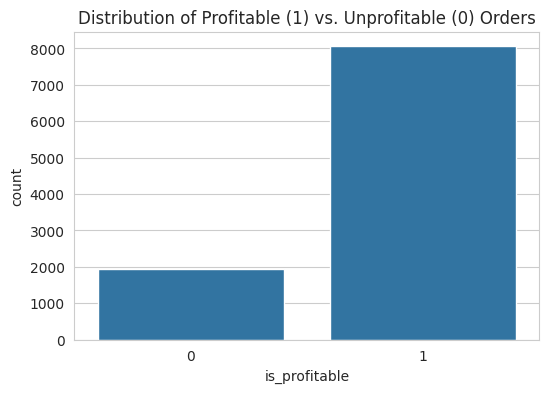

In [ ]:
# --- Check for Class Imbalance ---
print("Checking the distribution of the target variable 'is_profitable':")
class_distribution = df['is_profitable'].value_counts(normalize=True) * 100
print(class_distribution)

# Visualize the distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='is_profitable', data=df)
plt.title('Distribution of Profitable (1) vs. Unprofitable (0) Orders')
plt.show()

In [ ]:
# --- 3.2 Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X_encoded, target, test_size=0.2, random_state=42, stratify=target)
print(f"\nData split into training ({len(X_train)} rows) and testing ({len(X_test)} rows).")



Data split into training (7995 rows) and testing (1999 rows).


In [ ]:
from imblearn.over_sampling import SMOTE

# --- 3.2a Apply SMOTE to the Training Data ---
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"\nOriginal training set shape: {y_train.value_counts()}")
print(f"Resampled training set shape: {y_train_resampled.value_counts()}")


Original training set shape: is_profitable
1    6446
0    1549
Name: count, dtype: int64
Resampled training set shape: is_profitable
1    6446
0    6446
Name: count, dtype: int64


In [ ]:
# --- 3.3 Train a Random Forest Classifier ---
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_classifier.fit(X_train_resampled, y_train_resampled)
print("\nRandom Forest model trained.")


Random Forest model trained.



Model Accuracy: 93.35%

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.81      0.83       387
           1       0.96      0.96      0.96      1612

    accuracy                           0.93      1999
   macro avg       0.90      0.89      0.89      1999
weighted avg       0.93      0.93      0.93      1999


Confusion Matrix:


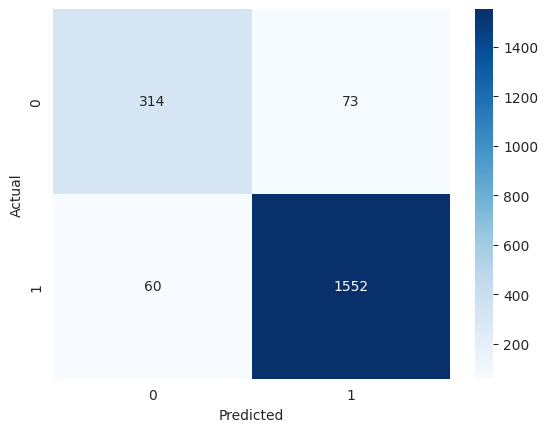

In [ ]:
# --- 3.4 Evaluate the Model ---
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.2%}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# --- 3.5 Feature Importance ---
# Check which features were most important for the prediction
importances = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False).reset_index(drop=True)

print("\n--- Top 10 Most Important Features ---")
display(importances.head(10))


--- Top 10 Most Important Features ---


,feature,importance
0,discount,0.676435
1,sales,0.150210
2,quantity,0.040086
3,ship_mode_Standard Class,0.021314
4,ship_mode_Second Class,0.016640
5,region_East,0.016162
6,category_Technology,0.015751
7,region_West,0.014516
8,region_South,0.011962
9,segment_Corporate,0.010529
